# Deep Learning Project

### Loading the pre-requisites

Importing the modules.

In [ ]:
from google.colab import drive
import os
from glob import glob
import random
random.seed(2708)
import math
import json
import cv2
import numpy as np
np.random.seed(2708)
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib
# Verifying is pydicom is downloaded
if importlib.util.find_spec('pydicom') is None:
  !pip install pydicom
import pydicom
import torch
torch.manual_seed(2708)
torch.cuda.manual_seed(2708)
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.1 MB/s eta 0:00:00


Mounting the drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Defining the data path and unzipping the data.

In [ ]:
drive_data_dir = '/content/drive/MyDrive/DL_Project_Data/triplets.zip'
drive_preprocessed_data_dir = '/content/drive/MyDrive/DL_Project_Data/preprocessed_data.zip'

print('Unzipping the data directory')
!unzip -q "$drive_data_dir" -d '/content/DL_Project_Data/'
if os.path.exists(drive_preprocessed_data_dir):
  print('Unzipping the preprocessed data directory')
  !unzip -q "$drive_preprocessed_data_dir" -d '/content/DL_Project_Processed_Data/'

Unzipping the data directory
Unzipping the preprocessed data directory


### Data pre-processing and visualiation

Loading the data and defining the directories.

In [ ]:
data_dir = '/content/DL_Project_Data/'
with open('/content/DL_Project_Data/labels.json', 'r') as f:
    data_label = json.load(f)
triplets_data = []
preprocessed_data_dir = '/content/DL_Project_Processed_Data/'

Creating a function to load, pre-process and generate 3 representations from a DICOM example.

In [ ]:
def convert_file_to_3channel(dcm_path, toImageNet=False, output_size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Loading the file data
    ds = pydicom.dcmread(dcm_path)
    # Loading the pixel values
    img = ds.pixel_array.astype(np.float32)
    # Converting to Hounsfield Units (HU)
    intercept = float(ds.RescaleIntercept)
    slope = float(ds.RescaleSlope)
    hu = img * slope + intercept
    # Defining the window presets
    # brain, subdural and bone
    windows = [(40, 80), (80, 200), (600, 2800)]
    # Windowing the images according to the three presets
    channels = []
    for center, width in windows:
        mn = center - width // 2
        mx = center + width // 2
        win = np.clip(hu, mn, mx)
        # Normalizing to [0, 1]
        norm = (win - mn) / (mx - mn)
        # Resizing to the output size
        if toImageNet:
            norm = cv2.resize(norm, output_size, interpolation=cv2.INTER_LINEAR)
        channels.append(norm)
    # Stacking into (3, H, W)
    three_chan = np.stack(channels, axis=0).astype(np.float32)
    # Applying ImageNet normalization
    if toImageNet:
        mean_values = np.array(mean, dtype=np.float32).reshape(3, 1, 1)
        std_values = np.array(std, dtype=np.float32).reshape(3, 1, 1)
        three_chan = (three_chan - mean_values) / std_values
    return three_chan

Creating a function to order the slices.

In [ ]:
def get_z_position(fpath):
    # Reading each data file
    dcm = pydicom.dcmread(fpath, stop_before_pixels=True)
    # Extrcating the image position patient data which provides the z-axis (depth / sequencial) position
    pos = dcm.ImagePositionPatient
    if pos is not None:
        # Returning the depth coordinate
        return float(pos[2])
    else:
        # If the depth coordinate is not present then appending it to the end
        return float('inf')

Creating a function to view all the 3 channels for multiple triplets.

In [ ]:
def display_triplets(triplets_data, triplets_per_row=4):
    # Calculating the number of rows and columns needed
    num_triplets = len(triplets_data)
    num_rows = math.ceil(num_triplets/triplets_per_row)
    # Plotting for each row
    for row_number in range(num_rows):
        row_triplets_data = triplets_data[row_number*triplets_per_row:(row_number+1)*triplets_per_row]
        fig, axes = plt.subplots(3, triplets_per_row*3, figsize=(triplets_per_row * 7.5, 7.5))
        plt.subplots_adjust(wspace=0.05, hspace=0.05)
        # Sweeping over all the row triplet data
        for i, triplet in enumerate(row_triplets_data):
            triplet_slices = triplet['slices']
            triplet_label = triplet['label']
            # Ordering the data
            triplet_slices_sorted = sorted(triplet_slices, key=get_z_position)
            # Calculating the triplet's position in the grid
            triplet_col = i % triplets_per_row
            # Looping over each triplet
            for slice_idx in range(3):
                dcm_path = triplet_slices_sorted[slice_idx]
                # Processing the DICOM file to get 3 channels
                three_chan_img = convert_file_to_3channel(dcm_path, toImageNet=True)
                # Viewing the three channels per slice
                for channel_idx in range(3):
                    # Viewing the data
                    ax = axes[slice_idx, triplet_col * 3 + channel_idx]
                    ax.imshow(three_chan_img[channel_idx, :, :], cmap='gray')
                    if slice_idx == 0 and channel_idx == 1:
                        ax.set_title(f'|--------------Label: {triplet_label}--------------|', fontsize=20, pad=10)
                    ax.axis('off')
        plt.show()


Visualizing all the three channels for one triplet per class.

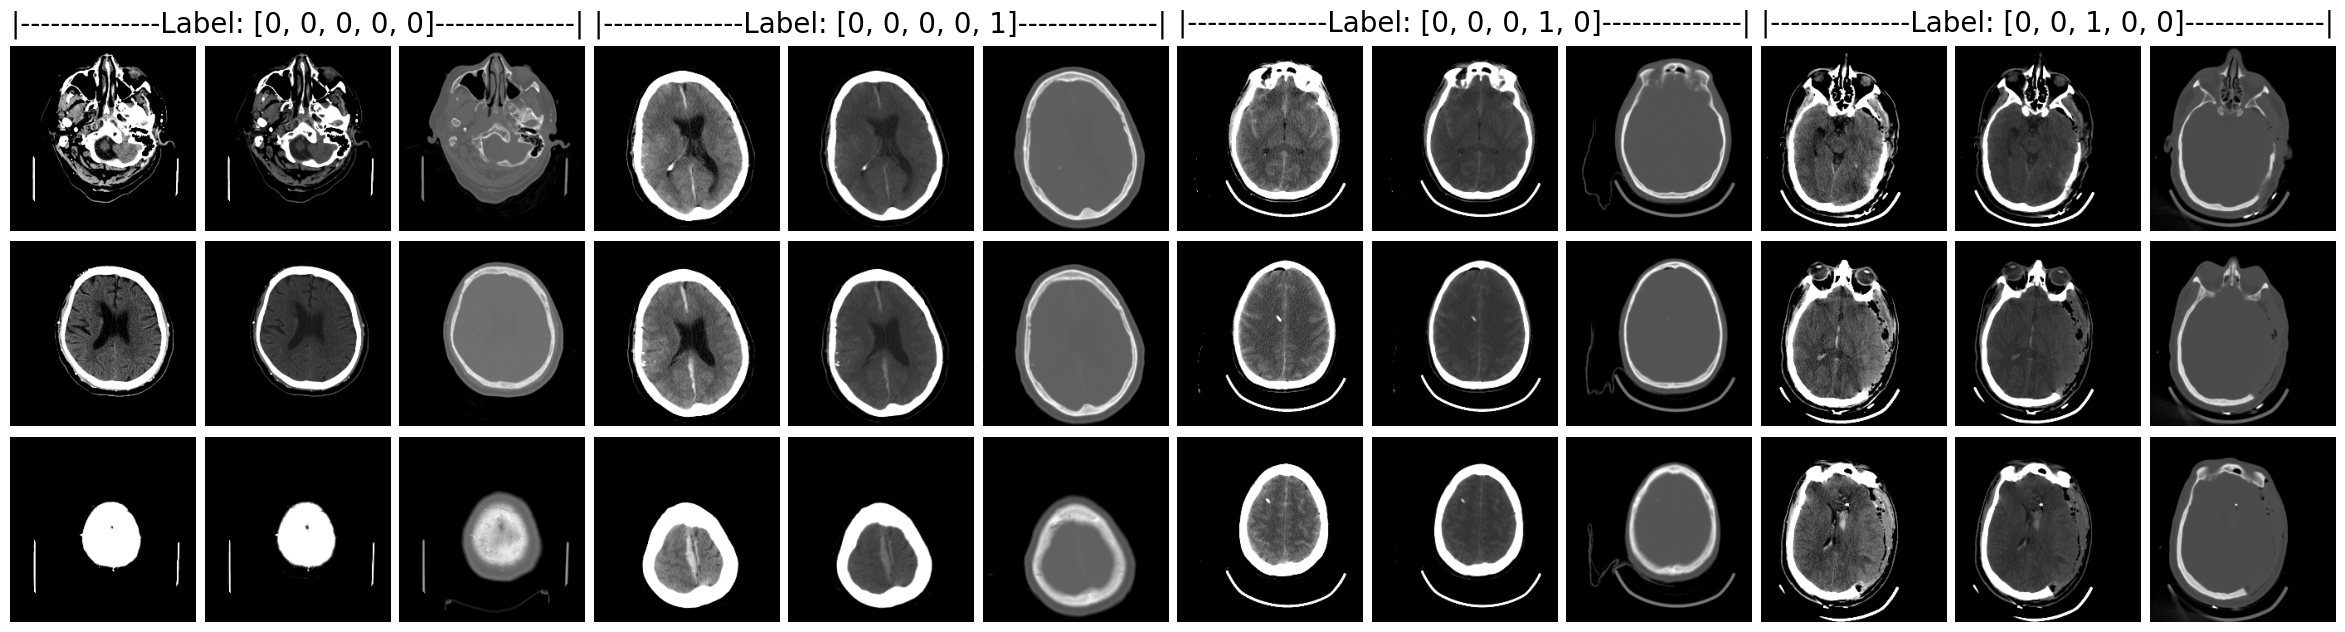

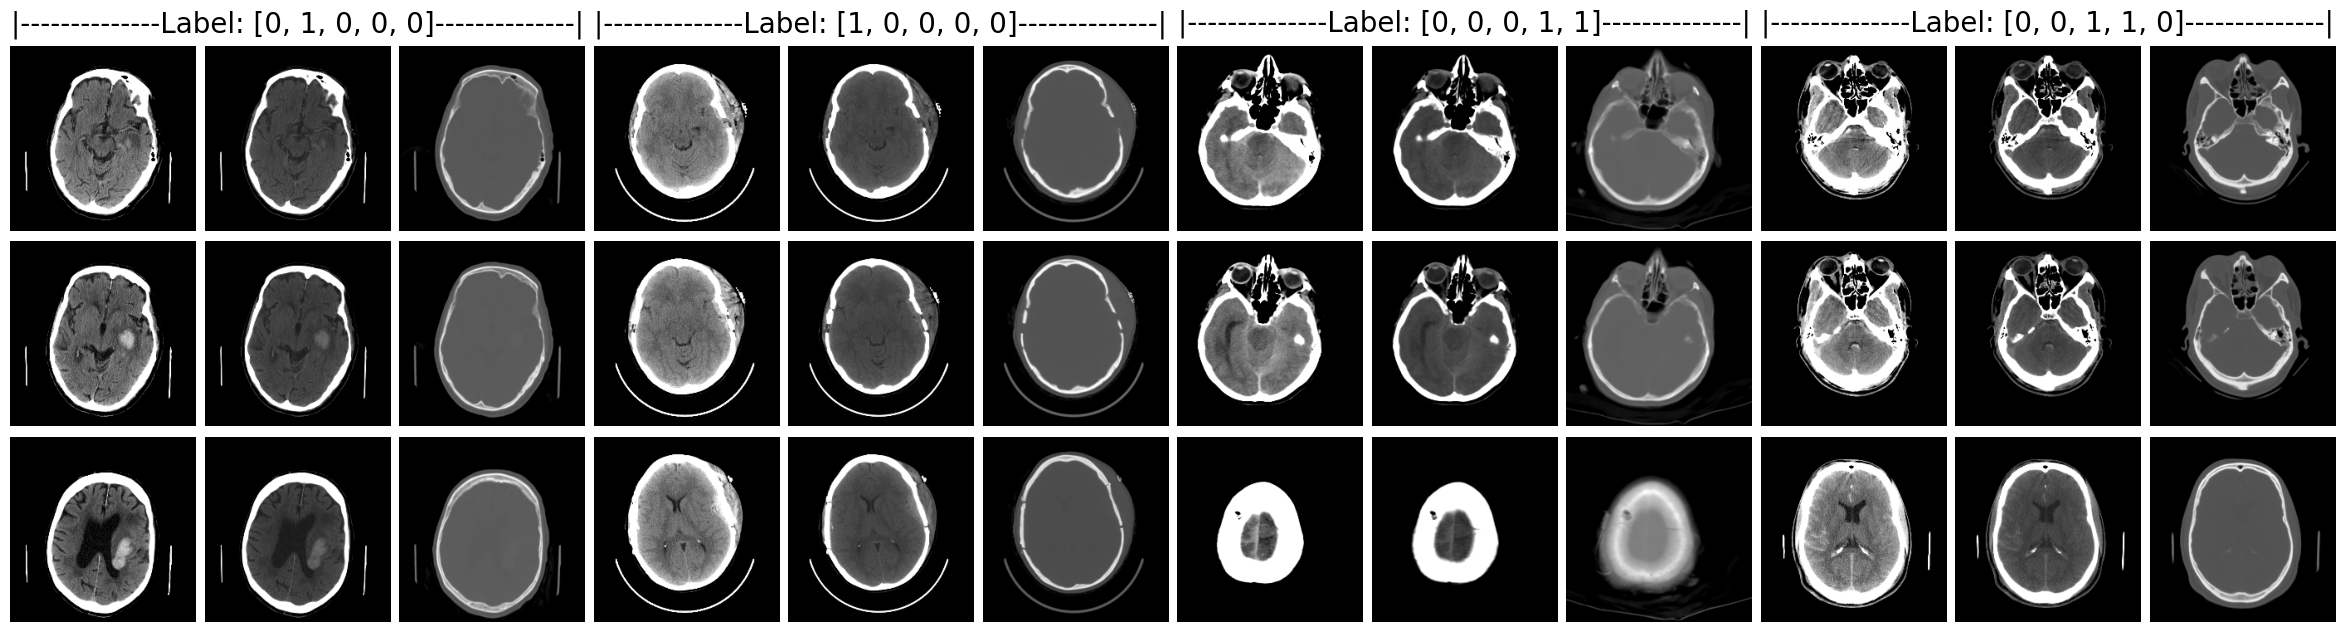

In [ ]:
# Listing all folders in the data directory
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
folders = sorted(folders)
# As we want two examples from the multiple class
folders.append(folders[-1])

# Initializing the randomly selected data list as an empty list
triplets_data = []

# Looping over each folder
for folder_name in folders:
    folder_path = os.path.join(data_dir, folder_name)
    # Listing all the sub-folder in the folder
    sub_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    # Randomly choosing a sub-folder
    selected_sub_folder = random.choice(sub_folders)
    # Taking the files from the chosen sub-folder
    selected_files = os.listdir(os.path.join(folder_path, selected_sub_folder))
    # Extracting the label
    label = data_label[selected_sub_folder]
    # Placing the selected data in a dictionary
    triplet_dict = {
        'slices': [os.path.join(folder_path, selected_sub_folder, f) for f in selected_files],
        'label': label
    }
    # Appending the dictionary to the list
    triplets_data.append(triplet_dict)

# Visualizing the results
display_triplets(triplets_data, triplets_per_row=4)

Creating the dicom series dataset.

In [ ]:
class DicomSubSeriesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Initializing the parameters
        self.root_dir = root_dir
        self.transform = transform
        # Getting a list of all subdirectories for each group containing tiplet folders
        self.triplet_folders = [f.path for f in os.scandir(root_dir)  if f.is_dir() ]
        self.labels = data_label
    def __len__(self):
        return len(self.triplet_folders)
    def __getitem__(self, idx):
        triplet_folder = self.triplet_folders[idx]
        triplet_id = os.path.basename(triplet_folder)
        # Finding all .dcm files in the folder
        dicom_files = glob(os.path.join(triplet_folder, '*.dcm'))
        # Ordering the data
        dicom_files_sorted = sorted(dicom_files, key=get_z_position)
        # Reading the DICOM files, applying 3-channel windowing and stacking their pixel arrays
        images = []
        for file_path in dicom_files_sorted:
            channels = convert_file_to_3channel(file_path)
            images.append(channels)
        # Stack the images into a single pytorch tensor of shape (9, H, W)
        image_stack = torch.from_numpy(np.concatenate(images))
        # Applying the transfomrs
        if self.transform:
            image_stack = self.transform(image_stack)
        # Generating the labels / targets
        labels = self.labels[triplet_id]
        labels = torch.tensor(labels)
        return image_stack, triplet_folder, labels

Pre-processing the data.

In [ ]:
if not os.path.exists(preprocessed_data_dir):
    # Defining the transforms
    img_size = 224
    transforms = transforms.Compose(
        [
            transforms.Resize(size=(img_size, img_size), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406] * 3, std=[0.229, 0.224, 0.225] * 3),
        ]
    )
    # Pre-processing the data
    for group in os.scandir(data_dir):
        if not group.is_dir():
            continue
        print(f'Processing group: {group.name}')
        dataset = DicomSubSeriesDataset(root_dir=group.path, transform=transforms)
        # Defining the train, val and test split size
        dataset_size = len(dataset)
        train_size = int(0.8 * dataset_size)
        val_size = int(0.1 * dataset_size)
        test_size = dataset_size - train_size - val_size
        print(f'Total dataset size: {dataset_size}')
        print(f'Training set size: {train_size}')
        print(f'Validation set size: {val_size}')
        print(f'Test set size: {test_size}')
        # Splitting the data
        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        for folder, subset in [('train', train_dataset), ('val', val_dataset), ('test', test_dataset)]:
            # Creating the new destination path
            destination_folder = os.path.join(preprocessed_data_dir, folder, group.name)
            os.makedirs(destination_folder, exist_ok=True)
            # Saving and storing the data
            for i in tqdm(range(len(subset))):
                image_tensor, triplet_folder, label = subset[i]
                relative_path = os.path.relpath(triplet_folder, dataset.root_dir)
                destination_file = os.path.join(destination_folder, relative_path + '.pt')
                torch.save((image_tensor, label), destination_file)
    # Zipping the data
    !cd '/content/DL_Project_Processed_Data' && zip -rq "$drive_preprocessed_data_dir" .
else:
    print('Data already pre-processed')

Data already pre-processed


Creating the pre-processed dataset.

In [ ]:
class PreprocessedDataset(Dataset):
    def __init__(self, root_dir, tranform=None):
        # Initializing the parameters
        self.root_dir = root_dir
        self.transform = tranform
        # Recursively finding all files ending with .pt in the directory
        self.file_paths = sorted(
            glob(os.path.join(root_dir, "**", "*.pt"), recursive=True)
        )
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        # Loading the saved data (expected to be a tuple)
        image_tensor, label = torch.load(file_path)
        # Applying the transforms
        if self.transform:
            image_tensor = self.transform(image_tensor)
        return image_tensor, label

Loading and viewing the shape of the data.

In [ ]:
# Initializing the transforms
train_transforms = transforms.Compose([
    # Flipping horizontally randomly
    transforms.RandomHorizontalFlip(),
    # Not flipping vertically randomly as CT scans are always aligned
    # transforms.RandomVerticalFlip(),
    # Rotating upto +5 or -5 degrees randomly
    transforms.RandomRotation(5),
    # Translating/shifting the image by at most 5% vertically and horizontally randomly
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
])

# Generating the datasets
train_dataset = PreprocessedDataset("/content/DL_Project_Processed_Data/train", tranform=train_transforms)
val_dataset = PreprocessedDataset("/content/DL_Project_Processed_Data/val")
test_dataset = PreprocessedDataset("/content/DL_Project_Processed_Data/test")

# Building the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Pulling one batch from the first fold's training set
images, labels = next(iter(train_dataloader))

# Verifying the shape of the batch
print("Images tensor shape:", images.shape)
print("Labels tensor shape:", labels.shape)


Images tensor shape: torch.Size([32, 9, 224, 224])
Labels tensor shape: torch.Size([32, 5])


### Base Model

Defining the base model.

In [ ]:
class SliceSimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
        )
    def forward(self, x):
        x = self.features(x)
        return x

class TripletSimpleBiRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SliceSimpleCNN()
        self.rnn1 = nn.RNN(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.rnn2 = nn.RNN(
            input_size=256,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 5)
        )
    def forward(self, x):
        # Separating the channels into 3 slices
        slices = torch.chunk(x, 3, dim=1)
        # Extracting the features for each slice
        slice_features = []
        for slice_ in slices:
            slice_feat = self.feature_extractor(slice_)
            slice_features.append(slice_feat)
        # Stacking the features
        triplet_features = torch.stack(slice_features, dim=1)
        # Generating the RNN outcomes
        rnn_outcomes, _ = self.rnn1(triplet_features)
        rnn_outcomes, _ = self.rnn2(rnn_outcomes)
        # Generating the classifications
        logits = self.classifier(rnn_outcomes)
        return logits

Creating a function to train a model and provide training and validation loss and accuracy.

In [ ]:
def train_validate_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs, device, early_stopping=False, patience=5):
    # Initializing the lists that will be returned
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    # Initializing the early stopping parameters
    if early_stopping:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    # Looping over the number of epochs
    for epoch in range(num_epochs):
        # Training the model via backpropogation
        model.train()
        train_loss = 0.0
        train_correct = 0
        for images, labels in tqdm(train_dataloader, desc=f" [Train] Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_correct += torch.sum(preds.bool() == labels.bool()).item()
        # Calculating the training loss and accuracy
        train_loss = train_loss / len(train_dataloader.dataset)
        train_acc = train_correct / (len(train_dataloader.dataset) * labels.size(1))
        # Appending the results to the lists
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        # Validating the model
        model.eval()
        val_loss = 0.0
        val_correct = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_dataloader, desc=f" [Val] Epoch {epoch+1}/{num_epochs}"):
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_correct += torch.sum(preds.bool() == labels.bool()).item()
        # Calculating the validation loss and accuracy
        val_loss = val_loss / len(val_dataloader.dataset)
        val_acc = val_correct / (len(val_dataloader.dataset) * labels.size(1))
        # Appending the results to the lists
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        # Performing the early stopping checks
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            else:
                patience_counter += 1
            # If early stopping doe stake place
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
    return train_losses, train_accuracies, val_losses, val_accuracies

Calculating the lossfunction weights.

In [ ]:
labels_list = []
for _, labels in train_dataset:
    labels = labels.unsqueeze(0)
    labels_list.append(labels)
all_labels = torch.cat(labels_list, dim=0).float()
N = all_labels.shape[0]
pos_counts = all_labels.sum(dim=0)
neg_counts = N - pos_counts
weights = np.log1p((neg_counts / pos_counts).numpy())
weights = torch.from_numpy(weights)
print(f'Weights: {weights}')

Weights: tensor([3.0336, 1.3885, 1.5245, 1.2727, 1.3604])


Compiling and training the base model.

In [ ]:
# Setting the device to GPU or CPU where we will train and test the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compiling the model
base_model = TripletSimpleBiRNN().to(device)
# Calculating the loss
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
# Setting the optimizer
optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3, weight_decay=1e-6)
# Training the model
base_train_losses, base_train_accuracies, base_val_losses, base_val_accuracies = train_validate_model(base_model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=100, device=device, early_stopping=True, patience=10)

 [Val] Epoch 1/100: 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]


Epoch 1/100 | Train Loss: 0.6675 | Train Acc: 0.6850 | Val Loss: 0.6543 | Val Acc: 0.7202


 [Val] Epoch 2/100: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch 2/100 | Train Loss: 0.5763 | Train Acc: 0.7784 | Val Loss: 0.5755 | Val Acc: 0.7930


 [Val] Epoch 3/100: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 3/100 | Train Loss: 0.5578 | Train Acc: 0.7863 | Val Loss: 0.5416 | Val Acc: 0.8061


 [Val] Epoch 4/100: 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]


Epoch 4/100 | Train Loss: 0.5314 | Train Acc: 0.8016 | Val Loss: 0.5960 | Val Acc: 0.8009


 [Val] Epoch 5/100: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


Epoch 5/100 | Train Loss: 0.5368 | Train Acc: 0.7933 | Val Loss: 0.5776 | Val Acc: 0.8158


 [Val] Epoch 6/100: 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]


Epoch 6/100 | Train Loss: 0.5172 | Train Acc: 0.8042 | Val Loss: 0.6556 | Val Acc: 0.7982


 [Val] Epoch 7/100: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch 7/100 | Train Loss: 0.5093 | Train Acc: 0.8056 | Val Loss: 0.6610 | Val Acc: 0.7000


 [Val] Epoch 8/100: 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]


Epoch 8/100 | Train Loss: 0.5011 | Train Acc: 0.8060 | Val Loss: 0.5319 | Val Acc: 0.8132


 [Val] Epoch 9/100: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 9/100 | Train Loss: 0.4939 | Train Acc: 0.8074 | Val Loss: 0.5449 | Val Acc: 0.7939


 [Val] Epoch 10/100: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


Epoch 10/100 | Train Loss: 0.4957 | Train Acc: 0.8054 | Val Loss: 0.9089 | Val Acc: 0.7456


 [Val] Epoch 11/100: 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]


Epoch 11/100 | Train Loss: 0.4879 | Train Acc: 0.8077 | Val Loss: 0.5965 | Val Acc: 0.7667


 [Val] Epoch 12/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 12/100 | Train Loss: 0.4830 | Train Acc: 0.8125 | Val Loss: 0.5046 | Val Acc: 0.8254


 [Val] Epoch 13/100: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


Epoch 13/100 | Train Loss: 0.4752 | Train Acc: 0.8198 | Val Loss: 0.5037 | Val Acc: 0.8193


 [Val] Epoch 14/100: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 14/100 | Train Loss: 0.4761 | Train Acc: 0.8176 | Val Loss: 0.7671 | Val Acc: 0.7974


 [Val] Epoch 15/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 15/100 | Train Loss: 0.4767 | Train Acc: 0.8170 | Val Loss: 0.5632 | Val Acc: 0.8254


 [Val] Epoch 16/100: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 16/100 | Train Loss: 0.4722 | Train Acc: 0.8176 | Val Loss: 0.6851 | Val Acc: 0.6965


 [Val] Epoch 17/100: 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


Epoch 17/100 | Train Loss: 0.4704 | Train Acc: 0.8171 | Val Loss: 0.7780 | Val Acc: 0.7351


 [Val] Epoch 18/100: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]


Epoch 18/100 | Train Loss: 0.4661 | Train Acc: 0.8153 | Val Loss: 0.5409 | Val Acc: 0.8149


 [Val] Epoch 19/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 19/100 | Train Loss: 0.4620 | Train Acc: 0.8232 | Val Loss: 0.8297 | Val Acc: 0.8184


 [Val] Epoch 20/100: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 20/100 | Train Loss: 0.4612 | Train Acc: 0.8187 | Val Loss: 0.7066 | Val Acc: 0.7474


 [Val] Epoch 21/100: 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]


Epoch 21/100 | Train Loss: 0.4610 | Train Acc: 0.8217 | Val Loss: 0.9047 | Val Acc: 0.7904


 [Val] Epoch 22/100: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]


Epoch 22/100 | Train Loss: 0.4563 | Train Acc: 0.8216 | Val Loss: 0.5175 | Val Acc: 0.8368


 [Val] Epoch 23/100: 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


Epoch 23/100 | Train Loss: 0.4474 | Train Acc: 0.8207 | Val Loss: 0.5884 | Val Acc: 0.7439


 [Val] Epoch 24/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 24/100 | Train Loss: 0.4512 | Train Acc: 0.8251 | Val Loss: 0.4885 | Val Acc: 0.8237


 [Val] Epoch 25/100: 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]


Epoch 25/100 | Train Loss: 0.4418 | Train Acc: 0.8212 | Val Loss: 0.6691 | Val Acc: 0.7544


 [Val] Epoch 26/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 26/100 | Train Loss: 0.4389 | Train Acc: 0.8287 | Val Loss: 0.5246 | Val Acc: 0.8298


 [Val] Epoch 27/100: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch 27/100 | Train Loss: 0.4358 | Train Acc: 0.8317 | Val Loss: 0.8042 | Val Acc: 0.7930


 [Val] Epoch 28/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 28/100 | Train Loss: 0.4536 | Train Acc: 0.8245 | Val Loss: 0.6467 | Val Acc: 0.7228


 [Val] Epoch 29/100: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 29/100 | Train Loss: 0.4270 | Train Acc: 0.8319 | Val Loss: 0.7055 | Val Acc: 0.8132


 [Val] Epoch 30/100: 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


Epoch 30/100 | Train Loss: 0.4320 | Train Acc: 0.8316 | Val Loss: 0.4575 | Val Acc: 0.8105


 [Val] Epoch 31/100: 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


Epoch 31/100 | Train Loss: 0.4364 | Train Acc: 0.8312 | Val Loss: 0.6188 | Val Acc: 0.7246


 [Val] Epoch 32/100: 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]


Epoch 32/100 | Train Loss: 0.4239 | Train Acc: 0.8337 | Val Loss: 0.5799 | Val Acc: 0.7851


 [Val] Epoch 33/100: 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]


Epoch 33/100 | Train Loss: 0.4346 | Train Acc: 0.8299 | Val Loss: 0.5974 | Val Acc: 0.7579


 [Val] Epoch 34/100: 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]


Epoch 34/100 | Train Loss: 0.4163 | Train Acc: 0.8363 | Val Loss: 0.6827 | Val Acc: 0.8202


 [Val] Epoch 35/100: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch 35/100 | Train Loss: 0.4149 | Train Acc: 0.8404 | Val Loss: 0.5760 | Val Acc: 0.7465


 [Val] Epoch 36/100: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


Epoch 36/100 | Train Loss: 0.4170 | Train Acc: 0.8393 | Val Loss: 0.7380 | Val Acc: 0.8193


 [Val] Epoch 37/100: 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]


Epoch 37/100 | Train Loss: 0.4133 | Train Acc: 0.8358 | Val Loss: 0.6129 | Val Acc: 0.7912


 [Val] Epoch 38/100: 100%|██████████| 8/8 [00:01<00:00,  4.14it/s]


Epoch 38/100 | Train Loss: 0.4049 | Train Acc: 0.8433 | Val Loss: 0.5884 | Val Acc: 0.6798


 [Val] Epoch 39/100: 100%|██████████| 8/8 [00:01<00:00,  4.13it/s]


Epoch 39/100 | Train Loss: 0.4103 | Train Acc: 0.8462 | Val Loss: 0.8829 | Val Acc: 0.8193


 [Val] Epoch 40/100: 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


Epoch 40/100 | Train Loss: 0.3911 | Train Acc: 0.8532 | Val Loss: 0.9223 | Val Acc: 0.7772


 [Val] Epoch 41/100: 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

Epoch 41/100 | Train Loss: 0.3950 | Train Acc: 0.8498 | Val Loss: 0.5707 | Val Acc: 0.8360
Early stopping at epoch 41


Saving the model.

In [ ]:
torch.save({
    'model_state_dict': base_model.state_dict(),
    'train_losses': base_train_losses,
    'train_accuracies': base_train_accuracies,
    'val_losses': base_val_losses,
    'val_accuracies': base_val_accuracies
}, 'base_model.pth')

Loading the model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = TripletSimpleBiRNN().to(device)
checkpoint = torch.load('base_model.pth')
base_model.load_state_dict(checkpoint['model_state_dict'])
base_train_losses = checkpoint['train_losses']
base_train_accuracies = checkpoint['train_accuracies']
base_val_losses = checkpoint['val_losses']
base_val_accuracies = checkpoint['val_accuracies']

Creating a function to plot the train and validation loss and accuracy over the epochs.

In [ ]:
def plot_loss_and_accuracy(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plotting the train and validation loass and accuracy over the epochs.

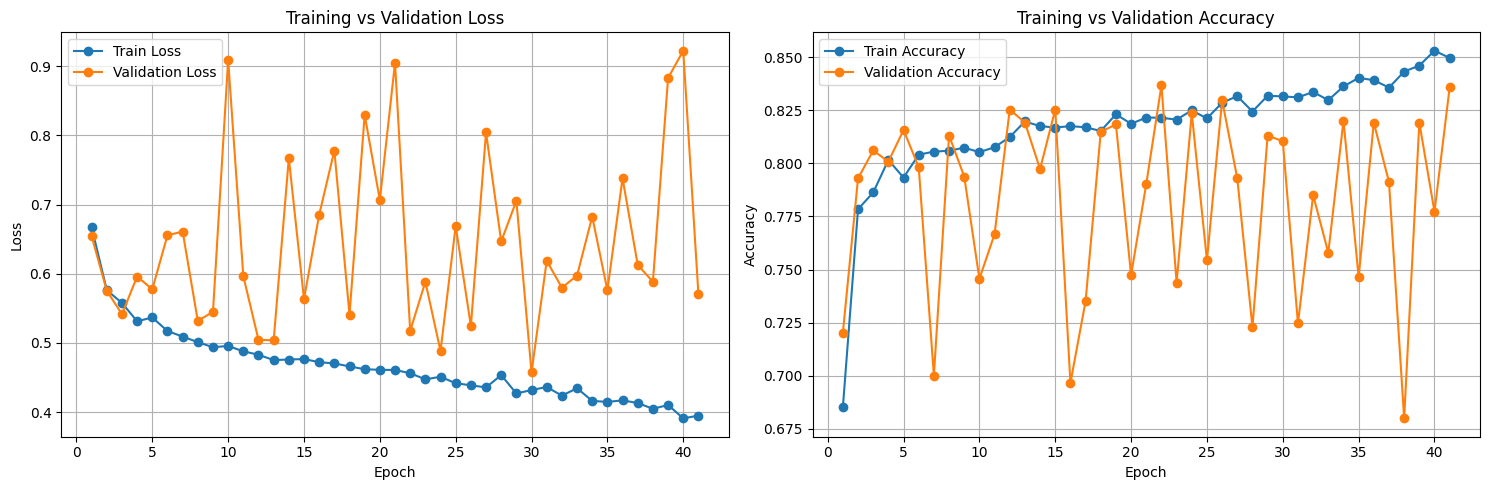

In [ ]:
plot_loss_and_accuracy(base_train_losses, base_train_accuracies, base_val_losses, base_val_accuracies)

Creating a function to test a model and provide evaluation scores and plots.

In [ ]:
def test_model(model, test_dataloader, loss_fn, device):
    model.eval()
    # Generating the model outputs
    test_loss = 0.0
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc=f"[Test]"):
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * images.size(0)
            test_outputs.append(outputs.cpu().numpy())
            test_labels.append(labels.cpu().numpy())
    # Calculating the test loss
    test_loss = test_loss / len(test_dataloader.dataset)
    print(f"Test Loss: {test_loss:.4f}")
    test_outputs = np.concatenate(test_outputs, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)
    # Infering the best threshold
    best_threshold = 0.0
    best_acc, best_sens, best_spec, best_prec, best_npv, best_f1 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    for threshold in np.arange(0.0, 1.0, 0.01):
        binary_outputs = (torch.sigmoid(torch.from_numpy(test_outputs)) > threshold).float().numpy()
        acc, sens, spec, prec, npv, f1 = [], [], [], [], [], []
        for i in range(binary_outputs.shape[1]):
            outputs = binary_outputs[:, i]
            labels = test_labels[:, i]
            cm = confusion_matrix(labels, outputs)
            tn, fp, fn, tp = cm.ravel()
            acc.append((tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0)
            sens.append(tp / (tp + fn) if (tp + fn) != 0 else 0)
            spec.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
            prec.append(tp / (tp + fp) if (tp + fp) != 0 else 0)
            npv.append(tn / (tn + fn) if (tn + fn) != 0 else 0)
            f1.append(2 * (prec[-1] * sens[-1]) / (prec[-1] + sens[-1]) if (prec[-1] + sens[-1]) != 0 else 0)
        mean_acc = np.mean(acc)
        mean_sens = np.mean(sens)
        mean_spec = np.mean(spec)
        mean_prec = np.mean(prec)
        mean_npv = np.mean(npv)
        mean_f1 = np.mean(f1)
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_acc = mean_acc
            best_sens = mean_sens
            best_spec = mean_spec
            best_prec = mean_prec
            best_npv = mean_npv
            best_threshold = threshold
    print(f"Best Threshold: {best_threshold:.4f}| Best Accuracy: {best_acc:.4f}| Best Sensitivity: {best_sens:.4f}| Best Specificity: {best_spec:.4f}| Best Precision: {best_prec:.4f}| Best Negative Predictive Value: {best_npv:.4f}| Best F1 Score: {best_f1:.4f}")
    # Generating the confusion matrices for each subtype using the best threshold
    binary_outputs = (torch.sigmoid(torch.from_numpy(test_outputs)) > best_threshold).float().numpy()
    for i in range(binary_outputs.shape[1]):
        outputs = binary_outputs[:, i]
        labels = test_labels[:, i]
        cm = confusion_matrix(labels, outputs)
        df_cm = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
        print(f"Confusion Matrix for Subtype {i+1}:")
        print(df_cm)
    # Diplaying the ROC for each subtype along with its ROC AUC values
    plt.figure(figsize=(8, 8))
    for i in range(binary_outputs.shape[1]):
        outputs = torch.sigmoid(torch.from_numpy(test_outputs))[:, i]
        labels = test_labels[:, i]
        fpr, tpr, _ = roc_curve(labels, outputs)
        roc_auc = roc_auc_score(labels, outputs)
        plt.plot(fpr, tpr, label=f'ROC Curve for Subtype {i+1} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Testing the base model.

[Test]: 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Test Loss: 0.4701
Best Threshold: 0.2900| Best Accuracy: 0.7432| Best Sensitivity: 0.8010| Best Specificity: 0.7351| Best Precision: 0.4757| Best Negative Predictive Value: 0.9202| Best F1 Score: 0.5568
Confusion Matrix for Subtype 1:
          Predicted 0  Predicted 1
Actual 0          146           72
Actual 1            1           10
Confusion Matrix for Subtype 2:
          Predicted 0  Predicted 1
Actual 0          150           23
Actual 1           14           42
Confusion Matrix for Subtype 3:
          Predicted 0  Predicted 1
Actual 0          162           15
Actual 1            9           43
Confusion Matrix for Subtype 4:
          Predicted 0  Predicted 1
Actual 0          115           48
Actual 1           22           44
Confusion Matrix for Subtype 5:
          Predicted 0  Predicted 1
Actual 0           87           81
Actual 1            9           52


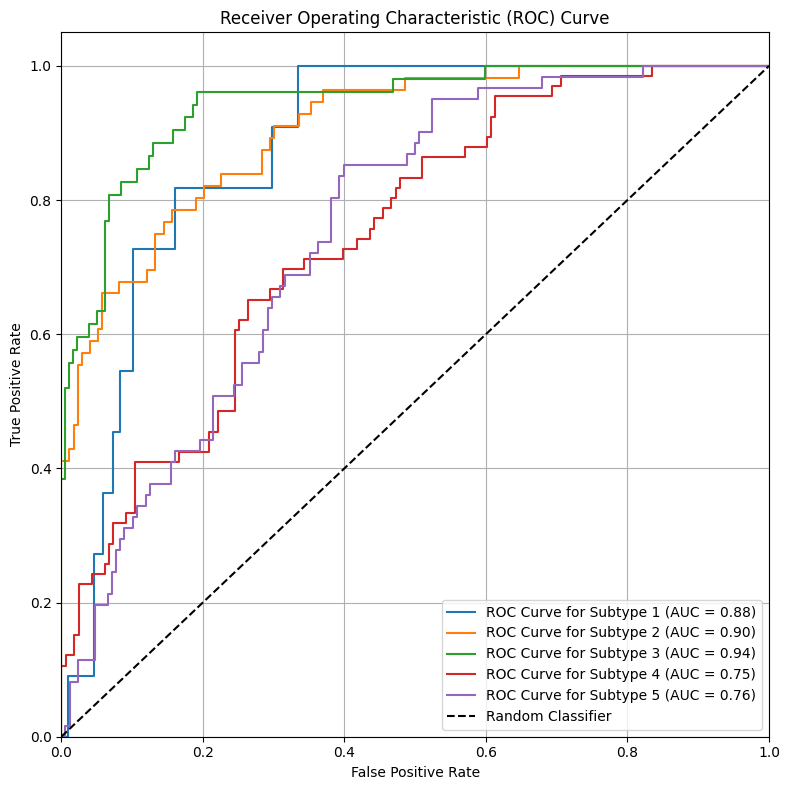

In [ ]:
test_model(base_model, test_dataloader, loss_fn, device)

### Final Model

Defining the final model.

In [ ]:
class SliceResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        base_model.fc = nn.Identity()
        # Freezing all but the last few layers
        for param in base_model.parameters():
            param.requires_grad = False
        for param in base_model.layer4.parameters():
            param.requires_grad = True
        self.base_model = base_model
    def forward(self, x):
        return self.base_model(x)

class TripletBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SliceResNet50()
        self.lstm1 = nn.LSTM(
            input_size=2048,
            hidden_size=256,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.lstm2 = nn.LSTM(
            input_size=512,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        slices = torch.chunk(x, 3, dim=1)
        slice_features = []
        for slice_ in slices:
            slice_feat = self.feature_extractor(slice_)
            slice_features.append(slice_feat)
        triplet_features = torch.stack(slice_features, dim=1)
        lstm_outcomes, _ = self.lstm1(triplet_features)
        lstm_outcomes, _ = self.lstm2(lstm_outcomes)
        logits = self.classifier(lstm_outcomes)
        return logits

Compiling and training the final model.

In [ ]:
final_model = TripletBiLSTM().to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights.to(device))
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3, weight_decay=1e-6)
final_train_losses, final_train_accuracies, final_val_losses, final_val_accuracies = train_validate_model(final_model, train_dataloader, val_dataloader, loss_fn, optimizer, num_epochs=100, device=device, early_stopping=True, patience=10)

 [Val] Epoch 1/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 1/100 | Train Loss: 0.6770 | Train Acc: 0.6514 | Val Loss: 0.5541 | Val Acc: 0.8079


 [Val] Epoch 2/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 2/100 | Train Loss: 0.5515 | Train Acc: 0.7999 | Val Loss: 0.5601 | Val Acc: 0.7965


 [Val] Epoch 3/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 3/100 | Train Loss: 0.5153 | Train Acc: 0.8130 | Val Loss: 0.5265 | Val Acc: 0.8175


 [Val] Epoch 4/100: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


Epoch 4/100 | Train Loss: 0.4836 | Train Acc: 0.8296 | Val Loss: 0.4872 | Val Acc: 0.8254


 [Val] Epoch 5/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 5/100 | Train Loss: 0.4716 | Train Acc: 0.8288 | Val Loss: 0.4757 | Val Acc: 0.8272


 [Val] Epoch 6/100: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


Epoch 6/100 | Train Loss: 0.4845 | Train Acc: 0.8189 | Val Loss: 0.4627 | Val Acc: 0.8404


 [Val] Epoch 7/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 7/100 | Train Loss: 0.4535 | Train Acc: 0.8328 | Val Loss: 0.5101 | Val Acc: 0.8096


 [Val] Epoch 8/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 8/100 | Train Loss: 0.4424 | Train Acc: 0.8395 | Val Loss: 0.4530 | Val Acc: 0.8263


 [Val] Epoch 9/100: 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Epoch 9/100 | Train Loss: 0.4372 | Train Acc: 0.8422 | Val Loss: 0.5379 | Val Acc: 0.8132


 [Val] Epoch 10/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 10/100 | Train Loss: 0.4594 | Train Acc: 0.8293 | Val Loss: 0.4232 | Val Acc: 0.8342


 [Val] Epoch 11/100: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


Epoch 11/100 | Train Loss: 0.4356 | Train Acc: 0.8373 | Val Loss: 0.4153 | Val Acc: 0.8544


 [Val] Epoch 12/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 12/100 | Train Loss: 0.4306 | Train Acc: 0.8374 | Val Loss: 0.4930 | Val Acc: 0.8325


 [Val] Epoch 13/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 13/100 | Train Loss: 0.4277 | Train Acc: 0.8453 | Val Loss: 0.4044 | Val Acc: 0.8535


 [Val] Epoch 14/100: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Epoch 14/100 | Train Loss: 0.4205 | Train Acc: 0.8425 | Val Loss: 0.3995 | Val Acc: 0.8667


 [Val] Epoch 15/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 15/100 | Train Loss: 0.4067 | Train Acc: 0.8540 | Val Loss: 0.4081 | Val Acc: 0.8535


 [Val] Epoch 16/100: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


Epoch 16/100 | Train Loss: 0.4115 | Train Acc: 0.8486 | Val Loss: 0.4560 | Val Acc: 0.8307


 [Val] Epoch 17/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 17/100 | Train Loss: 0.3913 | Train Acc: 0.8618 | Val Loss: 0.4082 | Val Acc: 0.8474


 [Val] Epoch 18/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 18/100 | Train Loss: 0.3854 | Train Acc: 0.8603 | Val Loss: 0.3846 | Val Acc: 0.8649


 [Val] Epoch 19/100: 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Epoch 19/100 | Train Loss: 0.3751 | Train Acc: 0.8632 | Val Loss: 0.4517 | Val Acc: 0.8316


 [Val] Epoch 20/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 20/100 | Train Loss: 0.3730 | Train Acc: 0.8699 | Val Loss: 0.3590 | Val Acc: 0.8798


 [Val] Epoch 21/100: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


Epoch 21/100 | Train Loss: 0.3675 | Train Acc: 0.8721 | Val Loss: 0.3935 | Val Acc: 0.8561


 [Val] Epoch 22/100: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


Epoch 22/100 | Train Loss: 0.3594 | Train Acc: 0.8719 | Val Loss: 0.3954 | Val Acc: 0.8482


 [Val] Epoch 23/100: 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


Epoch 23/100 | Train Loss: 0.3710 | Train Acc: 0.8702 | Val Loss: 0.3684 | Val Acc: 0.8614


 [Val] Epoch 24/100: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Epoch 24/100 | Train Loss: 0.3638 | Train Acc: 0.8723 | Val Loss: 0.3996 | Val Acc: 0.8605


 [Val] Epoch 25/100: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


Epoch 25/100 | Train Loss: 0.3517 | Train Acc: 0.8798 | Val Loss: 0.3946 | Val Acc: 0.8675


 [Val] Epoch 26/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 26/100 | Train Loss: 0.3571 | Train Acc: 0.8719 | Val Loss: 0.4412 | Val Acc: 0.8421


 [Val] Epoch 27/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 27/100 | Train Loss: 0.3528 | Train Acc: 0.8761 | Val Loss: 0.3603 | Val Acc: 0.8693


 [Val] Epoch 28/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 28/100 | Train Loss: 0.3372 | Train Acc: 0.8839 | Val Loss: 0.3861 | Val Acc: 0.8693


 [Val] Epoch 29/100: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 29/100 | Train Loss: 0.3315 | Train Acc: 0.8835 | Val Loss: 0.3863 | Val Acc: 0.8684


 [Val] Epoch 30/100: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


Epoch 30/100 | Train Loss: 0.3204 | Train Acc: 0.8899 | Val Loss: 0.3353 | Val Acc: 0.8833


 [Val] Epoch 31/100: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


Epoch 31/100 | Train Loss: 0.3211 | Train Acc: 0.8892 | Val Loss: 0.3468 | Val Acc: 0.8833


 [Val] Epoch 32/100: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Epoch 32/100 | Train Loss: 0.3440 | Train Acc: 0.8741 | Val Loss: 0.3446 | Val Acc: 0.8693


 [Val] Epoch 33/100: 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


Epoch 33/100 | Train Loss: 0.3152 | Train Acc: 0.8887 | Val Loss: 0.3592 | Val Acc: 0.8763


 [Val] Epoch 34/100: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


Epoch 34/100 | Train Loss: 0.3098 | Train Acc: 0.8912 | Val Loss: 0.4133 | Val Acc: 0.8623


 [Val] Epoch 35/100: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


Epoch 35/100 | Train Loss: 0.3051 | Train Acc: 0.8974 | Val Loss: 0.3303 | Val Acc: 0.8895


 [Val] Epoch 36/100: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


Epoch 36/100 | Train Loss: 0.2896 | Train Acc: 0.9004 | Val Loss: 0.3662 | Val Acc: 0.8904


 [Val] Epoch 37/100: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Epoch 37/100 | Train Loss: 0.2831 | Train Acc: 0.9031 | Val Loss: 0.3856 | Val Acc: 0.8904


 [Val] Epoch 38/100: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


Epoch 38/100 | Train Loss: 0.3146 | Train Acc: 0.8905 | Val Loss: 0.3463 | Val Acc: 0.8754


 [Val] Epoch 39/100: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Epoch 39/100 | Train Loss: 0.2889 | Train Acc: 0.8962 | Val Loss: 0.3115 | Val Acc: 0.8956


 [Val] Epoch 40/100: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


Epoch 40/100 | Train Loss: 0.2698 | Train Acc: 0.9108 | Val Loss: 0.3150 | Val Acc: 0.9009


 [Val] Epoch 41/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 41/100 | Train Loss: 0.2965 | Train Acc: 0.8985 | Val Loss: 0.3173 | Val Acc: 0.8991


 [Val] Epoch 42/100: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 42/100 | Train Loss: 0.2939 | Train Acc: 0.8967 | Val Loss: 0.3115 | Val Acc: 0.8965


 [Val] Epoch 43/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 43/100 | Train Loss: 0.2684 | Train Acc: 0.9105 | Val Loss: 0.3416 | Val Acc: 0.9000


 [Val] Epoch 44/100: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


Epoch 44/100 | Train Loss: 0.2875 | Train Acc: 0.9010 | Val Loss: 0.3331 | Val Acc: 0.8930


 [Val] Epoch 45/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 45/100 | Train Loss: 0.2664 | Train Acc: 0.9095 | Val Loss: 0.3078 | Val Acc: 0.9026


 [Val] Epoch 46/100: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


Epoch 46/100 | Train Loss: 0.2852 | Train Acc: 0.9035 | Val Loss: 0.3299 | Val Acc: 0.9018


 [Val] Epoch 47/100: 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Epoch 47/100 | Train Loss: 0.2554 | Train Acc: 0.9151 | Val Loss: 0.3361 | Val Acc: 0.8754


 [Val] Epoch 48/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 48/100 | Train Loss: 0.2829 | Train Acc: 0.9034 | Val Loss: 0.3345 | Val Acc: 0.8965


 [Val] Epoch 49/100: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


Epoch 49/100 | Train Loss: 0.2664 | Train Acc: 0.9102 | Val Loss: 0.2884 | Val Acc: 0.9105


 [Val] Epoch 50/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 50/100 | Train Loss: 0.2418 | Train Acc: 0.9181 | Val Loss: 0.3136 | Val Acc: 0.8886


 [Val] Epoch 51/100: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


Epoch 51/100 | Train Loss: 0.2373 | Train Acc: 0.9225 | Val Loss: 0.2991 | Val Acc: 0.8904


 [Val] Epoch 52/100: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


Epoch 52/100 | Train Loss: 0.2642 | Train Acc: 0.9081 | Val Loss: 0.3047 | Val Acc: 0.8904


 [Val] Epoch 53/100: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


Epoch 53/100 | Train Loss: 0.2449 | Train Acc: 0.9186 | Val Loss: 0.3275 | Val Acc: 0.9053


 [Val] Epoch 54/100: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


Epoch 54/100 | Train Loss: 0.2685 | Train Acc: 0.9129 | Val Loss: 0.2859 | Val Acc: 0.9175


 [Val] Epoch 55/100: 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]


Epoch 55/100 | Train Loss: 0.2466 | Train Acc: 0.9190 | Val Loss: 0.3218 | Val Acc: 0.9000


 [Val] Epoch 56/100: 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


Epoch 56/100 | Train Loss: 0.2873 | Train Acc: 0.8987 | Val Loss: 0.3139 | Val Acc: 0.9026


 [Val] Epoch 57/100: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


Epoch 57/100 | Train Loss: 0.2606 | Train Acc: 0.9111 | Val Loss: 0.3095 | Val Acc: 0.8939


 [Val] Epoch 58/100: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


Epoch 58/100 | Train Loss: 0.2452 | Train Acc: 0.9189 | Val Loss: 0.2997 | Val Acc: 0.8912


 [Val] Epoch 59/100: 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


Epoch 59/100 | Train Loss: 0.2385 | Train Acc: 0.9213 | Val Loss: 0.2721 | Val Acc: 0.9246


 [Val] Epoch 60/100: 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


Epoch 60/100 | Train Loss: 0.2323 | Train Acc: 0.9217 | Val Loss: 0.2973 | Val Acc: 0.9053


 [Val] Epoch 61/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 61/100 | Train Loss: 0.2289 | Train Acc: 0.9251 | Val Loss: 0.2516 | Val Acc: 0.9219


 [Val] Epoch 62/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 62/100 | Train Loss: 0.2416 | Train Acc: 0.9202 | Val Loss: 0.3270 | Val Acc: 0.8991


 [Val] Epoch 63/100: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Epoch 63/100 | Train Loss: 0.2377 | Train Acc: 0.9212 | Val Loss: 0.3499 | Val Acc: 0.9000


 [Val] Epoch 64/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 64/100 | Train Loss: 0.2066 | Train Acc: 0.9294 | Val Loss: 0.2649 | Val Acc: 0.9123


 [Val] Epoch 65/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


Epoch 65/100 | Train Loss: 0.2034 | Train Acc: 0.9318 | Val Loss: 0.2930 | Val Acc: 0.9061


 [Val] Epoch 66/100: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


Epoch 66/100 | Train Loss: 0.2045 | Train Acc: 0.9301 | Val Loss: 0.2955 | Val Acc: 0.9035


 [Val] Epoch 67/100: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


Epoch 67/100 | Train Loss: 0.2026 | Train Acc: 0.9317 | Val Loss: 0.2689 | Val Acc: 0.9140


 [Val] Epoch 68/100: 100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


Epoch 68/100 | Train Loss: 0.2131 | Train Acc: 0.9268 | Val Loss: 0.2974 | Val Acc: 0.9175


 [Val] Epoch 69/100: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


Epoch 69/100 | Train Loss: 0.1991 | Train Acc: 0.9332 | Val Loss: 0.4448 | Val Acc: 0.8535


 [Val] Epoch 70/100: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


Epoch 70/100 | Train Loss: 0.2157 | Train Acc: 0.9266 | Val Loss: 0.3558 | Val Acc: 0.8746


 [Val] Epoch 71/100: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


Epoch 71/100 | Train Loss: 0.2968 | Train Acc: 0.9010 | Val Loss: 0.3378 | Val Acc: 0.8904


 [Val] Epoch 72/100: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

Epoch 72/100 | Train Loss: 0.2438 | Train Acc: 0.9168 | Val Loss: 0.3057 | Val Acc: 0.9026
Early stopping at epoch 72


Saving the model.

In [ ]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'train_losses': final_train_losses,
    'train_accuracies': final_train_accuracies,
    'val_losses': final_val_losses,
    'val_accuracies': final_val_accuracies
}, 'final_model.pth')

Loading the model.

In [ ]:
final_model = TripletBiLSTM().to(device)
checkpoint = torch.load('final_model.pth')
final_model.load_state_dict(checkpoint['model_state_dict'])
final_train_losses = checkpoint['train_losses']
final_train_accuracies = checkpoint['train_accuracies']
final_val_losses = checkpoint['val_losses']
final_val_accuracies = checkpoint['val_accuracies']

Plotting the train and validation loass and accuracy over the epochs.

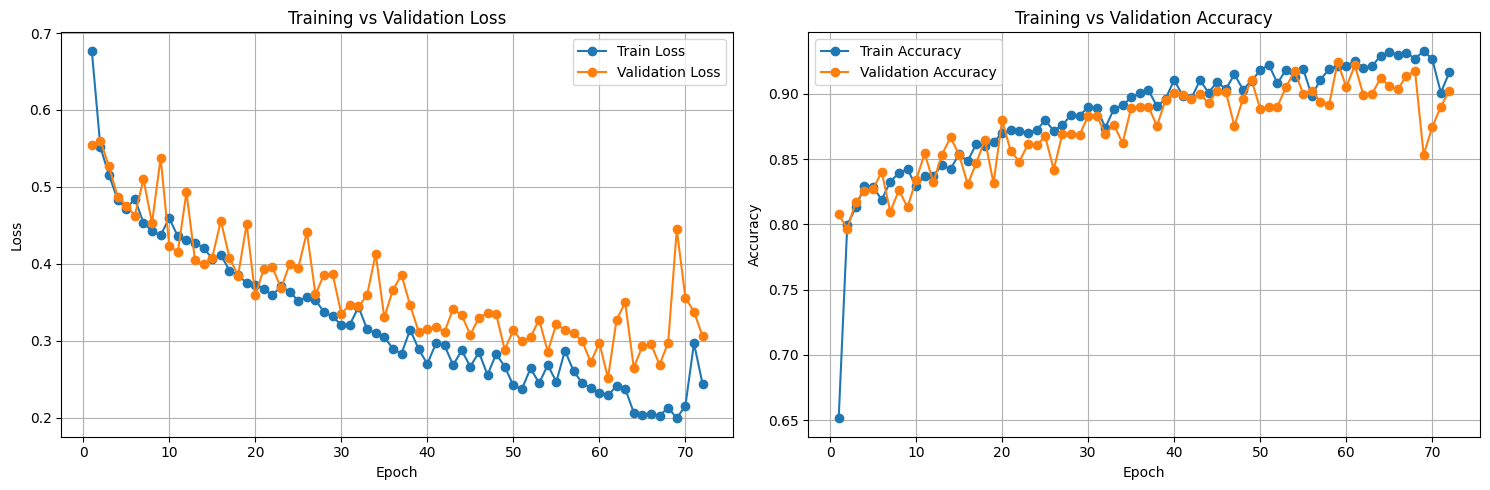

In [ ]:
plot_loss_and_accuracy(final_train_losses, final_train_accuracies, final_val_losses, final_val_accuracies)

Testing the final model.

[Test]: 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]


Test Loss: 0.2835
Best Threshold: 0.3800| Best Accuracy: 0.9118| Best Sensitivity: 0.7922| Best Specificity: 0.9427| Best Precision: 0.7524| Best Negative Predictive Value: 0.9431| Best F1 Score: 0.7618
Confusion Matrix for Subtype 1:
          Predicted 0  Predicted 1
Actual 0          209            9
Actual 1            3            8
Confusion Matrix for Subtype 2:
          Predicted 0  Predicted 1
Actual 0          165            8
Actual 1            8           48
Confusion Matrix for Subtype 3:
          Predicted 0  Predicted 1
Actual 0          162           15
Actual 1            4           48
Confusion Matrix for Subtype 4:
          Predicted 0  Predicted 1
Actual 0          158            5
Actual 1           22           44
Confusion Matrix for Subtype 5:
          Predicted 0  Predicted 1
Actual 0          154           14
Actual 1           13           48


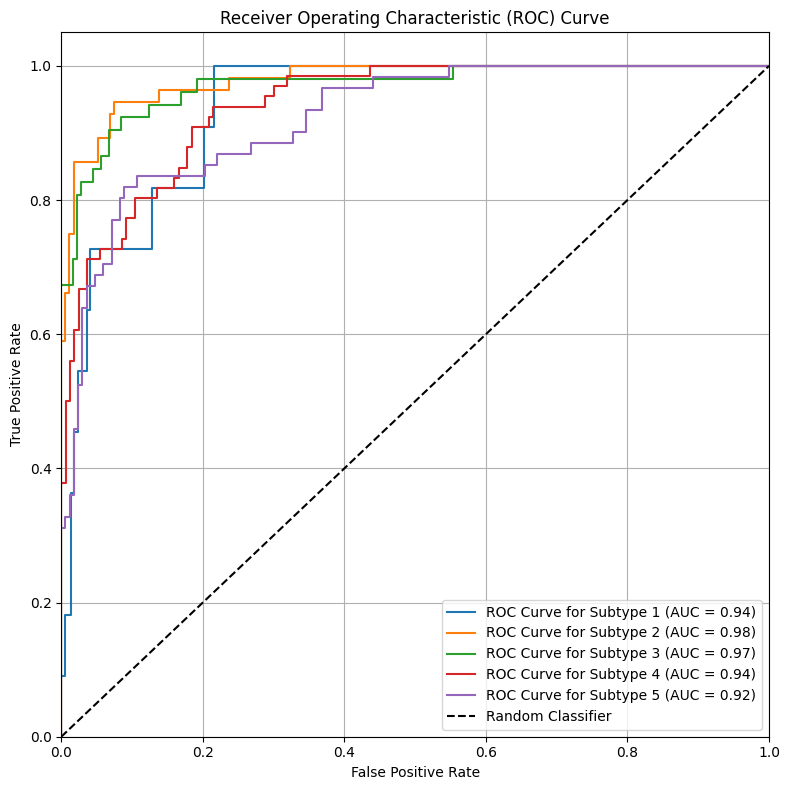

In [ ]:
test_model(final_model, test_dataloader, loss_fn, device)